In [ ]:
import numpy as np


data = np.load('drone_dataset\\background_20250414_142850.npz')


print(data.files)

['iq_samples']


In [2]:
iq_samples = data['iq_samples']
iq_samples.shape[0]

500

In [3]:
print(iq_samples[:5])

[[ -4. +4.j  -4. -6.j  -4. -1.j ...   3. +1.j   2. -1.j   2. -9.j]
 [  0. -4.j   0. +7.j   3. +4.j ...   3. -3.j  -4. +3.j   4. +4.j]
 [ -4. +9.j   2. -3.j   5. -1.j ...  29. -7.j -11.+29.j -18.-20.j]
 [ 14. -4.j  -4. -9.j  24. +0.j ...  -2. -8.j   0. -3.j  -4. +0.j]
 [  3. +0.j   1. +2.j   4. -6.j ...   5. -5.j   1. -8.j   5. +3.j]]


In [ ]:
import numpy as np

data1 = np.load('drone_dataset\\drone_data_20250414_144053.npz')


print(data1.files)

['iq_samples']


In [5]:
iq_samples1 = data['iq_samples']
iq_samples1.shape[0]

500

In [6]:
print(iq_samples1[:5])

[[ -4. +4.j  -4. -6.j  -4. -1.j ...   3. +1.j   2. -1.j   2. -9.j]
 [  0. -4.j   0. +7.j   3. +4.j ...   3. -3.j  -4. +3.j   4. +4.j]
 [ -4. +9.j   2. -3.j   5. -1.j ...  29. -7.j -11.+29.j -18.-20.j]
 [ 14. -4.j  -4. -9.j  24. +0.j ...  -2. -8.j   0. -3.j  -4. +0.j]
 [  3. +0.j   1. +2.j   4. -6.j ...   5. -5.j   1. -8.j   5. +3.j]]


## Training

In [1]:
import numpy as np
import pandas as pd
import pywt
from scipy.signal import welch, hilbert
from scipy.stats import skew, kurtosis, entropy, pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
def spectral_entropy(signal, fs):
    """
    Compute the spectral entropy of a signal.
    Inspired by [2102.11894v1] where spectral entropy helps assess frequency randomness.
    """
    f, Pxx = welch(signal, fs=fs)
    Pxx_norm = Pxx / np.sum(Pxx) if np.sum(Pxx) > 0 else Pxx
    return entropy(Pxx_norm)

def median_frequency(signal, fs):
    """
    Compute median frequency using the Welch power spectral density.
    This feature is referenced in several RF fingerprinting studies.
    """
    f, Pxx = welch(signal, fs=fs)
    cumulative_power = np.cumsum(Pxx)
    half_power = cumulative_power[-1] / 2.
    median_freq = f[np.searchsorted(cumulative_power, half_power)]
    return median_freq

def extract_additional_features(iq_data, fs=1.0):
    """
    Extract additional features from a 1D array of IQ samples.
    Features included:
      - Phase-domain: Mean and standard deviation of the phase.
      - Frequency-domain: Median frequency and spectral entropy (via Welch PSD).
      - Wavelet-domain: Energy of subbands via discrete wavelet transform.
      - Hilbert transform: Envelope mean and standard deviation.
    These features are motivated by several RF-based UAV detection studies
    (e.g., [2003.02656v1], [2102.11894v1], [2104.06614v1], [2107.04908v1]).
    """
    # Compute phase features
    phases = np.angle(iq_data)
    mean_phase = np.mean(phases)
    std_phase = np.std(phases)
    
    # Frequency-domain features
    mag = np.abs(iq_data)
    med_freq = median_frequency(mag, fs)
    spec_entropy = spectral_entropy(mag, fs)
    
    # Wavelet transform features: use a 3-level decomposition with the 'db4' wavelet
    coeffs = pywt.wavedec(mag, 'db4', level=3)
    wavelet_energies = [np.sum(c ** 2) for c in coeffs]
    
    # Hilbert transform: calculate envelope statistics
    analytic_signal = hilbert(mag)
    envelope = np.abs(analytic_signal)
    mean_envelope = np.mean(envelope)
    std_envelope = np.std(envelope)
    
    # Combine additional features
    additional_feats = [mean_phase, std_phase, med_freq, spec_entropy] + wavelet_energies + [mean_envelope, std_envelope]
    return additional_feats


def extract_features(iq_data, fs=1.0):
    """
    Extract a set of features from a 1D array of IQ samples (complex numbers).
    Original features (inspired by several RF detection methods):
      - Mean magnitude, standard deviation, skewness, kurtosis.
      - Total energy and peak frequency from FFT.
    """
    mag = np.abs(iq_data)
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    skew_mag = skew(mag)
    kurtosis_mag = kurtosis(mag)
    energy = np.sum(mag ** 2)
    
    N = len(iq_data)
    fft_vals = np.fft.fft(iq_data)
    fft_mag = np.abs(fft_vals)[:N // 2]
    freqs = np.fft.fftfreq(N, d=1/fs)[:N // 2]
    peak_freq = freqs[np.argmax(fft_mag)] if len(fft_mag) > 0 else 0.0
    
    return [mean_mag, std_mag, skew_mag, kurtosis_mag, energy, peak_freq]

def combine_features(iq_data, fs=1.0):
    """
    Combine the original feature set with additional features.
    """
    base_feats = extract_features(iq_data, fs)
    extra_feats = extract_additional_features(iq_data, fs)
    return base_feats + extra_feats


In [3]:
def convert_npz_to_npy(npz_path, key='iq_samples'):
    npy_path = os.path.splitext(npz_path)[0] + '.npy'
    if not os.path.exists(npy_path):
        with np.load(npz_path) as data:
            print(f"Converting {npz_path}: found keys {data.files}")
            arr = data[key]
            np.save(npy_path, arr)
            print(f"Saved uncompressed data as {npy_path}")
    else:
        print(f"{npy_path} already exists.")
    return npy_path

# ===== Process dataset using memory mapping and chunking =====
def process_dataset_memmap(npz_path, label, key='iq_samples', fs=1.0, chunk_size=10000):
    npy_path = convert_npz_to_npy(npz_path, key)
    iq_array = np.load(npy_path, mmap_mode='r')
    total = iq_array.shape[0]
    features_list = []
    labels_list = []
    print(f"Processing {npy_path} in chunks of {chunk_size}. Total samples: {total}")
    for start in range(0, total, chunk_size):
        end = min(total, start + chunk_size)
        chunk = iq_array[start:end]
        for sample in chunk:
            feats = combine_features(sample, fs)
            features_list.append(feats)
            labels_list.append(label)
        print(f"Processed samples {start} to {end}")
    return np.array(features_list), np.array(labels_list)




In [ ]:

background_path = r"drone_dataset\background_20250414_142850.npz"

drone_path = r"drone_dataset\drone_data_20250414_144053.npz"

In [ ]:

import os
X_bg, y_bg = process_dataset_memmap(background_path, label=0, fs=1.0, chunk_size=10000)
X_drone, y_drone = process_dataset_memmap(drone_path, label=1, fs=1.0, chunk_size=10000)

drone_dataset\background_20250414_142850.npy already exists.
Processing drone_dataset\background_20250414_142850.npy in chunks of 10000. Total samples: 500
Processed samples 0 to 500
drone_dataset\drone_data_20250414_144053.npy already exists.
Processing drone_dataset\drone_data_20250414_144053.npy in chunks of 10000. Total samples: 500
Processed samples 0 to 500


In [ ]:

X = np.vstack((X_bg, X_drone))
y = np.concatenate((y_bg, y_drone))

In [7]:
base_feature_names = ['mean_mag', 'std_mag', 'skew_mag', 'kurtosis_mag', 'energy', 'peak_freq']
extra_feature_names = [
    'mean_phase', 'std_phase', 'median_freq', 'spectral_entropy',
    'wavelet_energy_lev0', 'wavelet_energy_lev1', 'wavelet_energy_lev2', 'wavelet_energy_lev3',
    'mean_envelope', 'std_envelope'
]
all_feature_names = base_feature_names + extra_feature_names


In [8]:
df = pd.DataFrame(X, columns=all_feature_names)
df['label'] = y

print("Extracted features (first 5 rows):")
print(df.head())

Extracted features (first 5 rows):
    mean_mag    std_mag   skew_mag  kurtosis_mag        energy  peak_freq  \
0  10.793200  40.916374   7.769851     59.894256  1.432514e+09   0.105443   
1   7.367333  27.923982  11.923593    142.182651  6.672211e+08   0.102604   
2   5.234389   4.418577   5.680158     47.389508  3.753812e+07   0.299583   
3   6.008942   5.618207   5.227243     38.814094  5.413730e+07   0.000310   
4   6.878847  19.342600  11.334175    132.028617  3.371638e+08   0.105429   

   mean_phase  std_phase  median_freq  spectral_entropy  wavelet_energy_lev0  \
0    0.146657   1.810022     0.007812          3.008323         1.427295e+09   
1    0.146195   1.805832     0.011719          3.611070         6.625287e+08   
2    0.148308   1.805615     0.234375          4.841252         3.295407e+07   
3    0.142620   1.805944     0.210938          4.823992         4.868746e+07   
4    0.149117   1.804690     0.136719          4.267752         3.324488e+08   

   wavelet_energy_lev

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[all_feature_names], df['label'], test_size=0.2, random_state=42)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nDrone Classification Accuracy: {acc:.4f}")


Drone Classification Accuracy: 0.6750


In [11]:
print("\nFeature correlation with label (Pearson correlation):")
correlations = {}
for feat in all_feature_names:
    corr_coef, pval = pearsonr(df[feat], df['label'])
    correlations[feat] = corr_coef
    print(f"  {feat}: correlation = {corr_coef:.4f} (p-value = {pval:.4g})")



Feature correlation with label (Pearson correlation):
  mean_mag: correlation = 0.2383 (p-value = 2.248e-14)
  std_mag: correlation = 0.3525 (p-value = 1.25e-30)
  skew_mag: correlation = -0.1507 (p-value = 1.688e-06)
  kurtosis_mag: correlation = -0.0822 (p-value = 0.009317)
  energy: correlation = 0.2220 (p-value = 1.251e-12)
  peak_freq: correlation = 0.5768 (p-value = 9.126e-90)
  mean_phase: correlation = 0.6580 (p-value = 4.539e-125)
  std_phase: correlation = -0.3425 (p-value = 6.697e-29)
  median_freq: correlation = -0.0142 (p-value = 0.6533)
  spectral_entropy: correlation = -0.1976 (p-value = 2.908e-10)
  wavelet_energy_lev0: correlation = 0.2151 (p-value = 6.268e-12)
  wavelet_energy_lev1: correlation = 0.2501 (p-value = 1.007e-15)
  wavelet_energy_lev2: correlation = 0.2492 (p-value = 1.261e-15)
  wavelet_energy_lev3: correlation = 0.2433 (p-value = 6.137e-15)
  mean_envelope: correlation = 0.3188 (p-value = 4.601e-25)
  std_envelope: correlation = 0.3550 (p-value = 4.609e

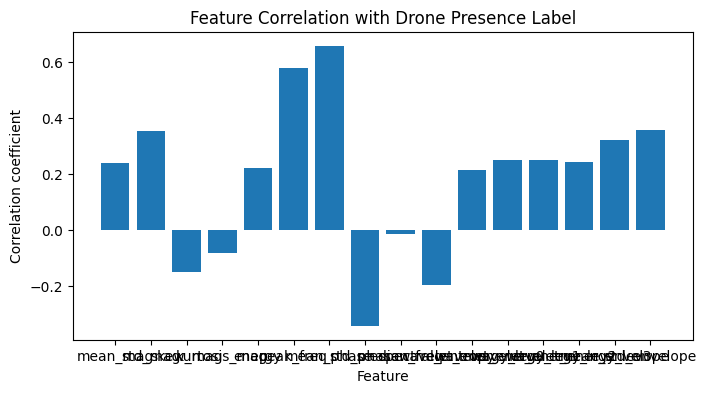

In [12]:
plt.figure(figsize=(8, 4))
plt.bar(correlations.keys(), correlations.values())
plt.xlabel('Feature')
plt.ylabel('Correlation coefficient')
plt.title('Feature Correlation with Drone Presence Label')
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nDrone Classification Accuracy (Random Forest): {acc:.4f}")


Drone Classification Accuracy (Random Forest): 0.9600


In [ ]:
import pickle


with open('random_forest_model_drone_detection.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)


In [ ]:
import joblib

joblib.dump(rf_clf, 'random_forest_model_drone_detection.joblib')


['random_forest_model_drone_detection.joblib']

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [21]:
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)


c:\Users\Lenovo\Desktop\GD-drone\gddrone\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
y_pred = xgb_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nDrone Classification Accuracy (XGBoost): {acc:.4f}")


Drone Classification Accuracy (XGBoost): 0.9650


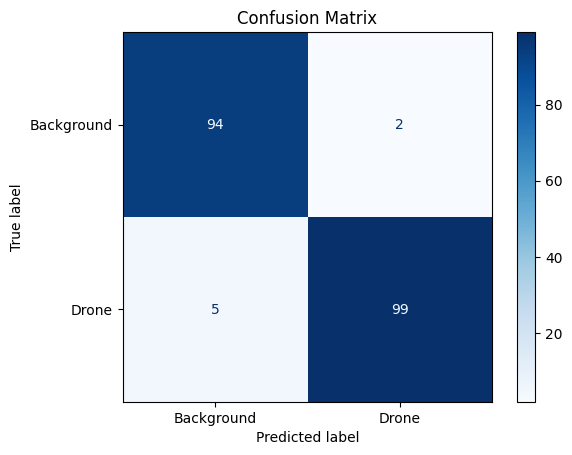

Classification Report:
               precision    recall  f1-score   support

  Background       0.95      0.98      0.96        96
       Drone       0.98      0.95      0.97       104

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



In [ ]:
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Drone'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


report = classification_report(y_test, y_pred, target_names=['Background', 'Drone'])
print("Classification Report:\n", report)

In [23]:



with open('xgboost_model_drone_detection.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)

In [24]:


joblib.dump(xgb_clf, 'xgboost_model_drone_detection.joblib')

['xgboost_model_drone_detection.joblib']